# Homework 3 - Logistic Regression
## BIOST 558 Spring 2020 
### Juan Solorio

#### Module and Data Preparation

In [1]:
# needed libraries

# data manipulation
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import linear_model

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load the data
spam = pd.read_table("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.data",sep=" ", header=None)
spam['indicator'] = pd.read_table("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/spam.traintest",header=None) 
spam = spam.dropna()
# Create our X matrix with the predictors and y vector with the response
X = spam.drop("indicator", axis=1)
X = pd.get_dummies(X, drop_first=True)
y = spam.indicator
y.replace(0,-1,inplace=True)
# Divide the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler = preprocessing.StandardScaler().fit(y_train.values.reshape(-1, 1))
# y_train = scaler.transform(y_train.values.reshape(-1, 1)).reshape((-1))
# y_test = scaler.transform(y_test.values.reshape(-1, 1)).reshape((-1))


### Exercise 1 
#### Logistic Regression Theory

For Logistic Regression we have the objective equation to minimize:

\begin{equation}
\min_{\beta}F(\beta) = \frac{1}{n}\sum_{i=1}^n log(1 + exp^{-y_ix^T_i\beta}) + \lambda\|\beta\|^2_2
\end{equation}

or equivalently

\begin{equation}
\min_{\beta}F(\beta) = \frac{1}{n}\sum_{i=1}^n log(1 + exp^{-y_i\sum^d_{j=1}x^T_{i,j}\beta_j}) + \lambda\sum_{j=1}^d\beta_j^2
\end{equation}

Using the machine learning convention for the labels that is $y_i\ \in$ {−1, +1}

Assuming $d=1$ and $n=1$, we can compute the $\nabla F$ as follows:

\begin{equation}
F(\beta) = log(1 + exp^{-yx\beta}) + \lambda\beta^2
\end{equation}
\begin{equation}
\Rightarrow \frac{\partial F}{\partial \beta} = \frac{(-yx)exp^{-yxb}}{(1 + exp^{-yx\beta})} + 2\lambda\beta
\end{equation}
\begin{equation}
\Rightarrow \nabla F(\beta) = 2\lambda \beta - \frac{yx}{(1 + exp^{-yx\beta})* exp^{yx\beta}}
\end{equation}
\begin{equation}
\Rightarrow \nabla F(\beta) = 2\lambda \beta - \frac{yx}{exp^{yx\beta} + 1}
\end{equation}


##### Function Definition

In [35]:
def Fx_logisticReg(b, lamda=0.5,X=X_train,y=y_train):
    h = X @ b * y
    return (1/len(y)) * sum(np.log(1 + np.exp(-h))) + (lamda * np.linalg.norm(b)**2)

In [36]:
def computegrad(b, lamda,X=X_train,y=y_train):
    h = X @ b * y 
    return 2*lamda*b - (1/len(y) * (X.T @ (y / (np.exp(h) + 1)))) 

In [135]:
def backtracking(beta, grad, eta_0,lamda,alpha=0.5,gamma=0.8):
    #F(B_t − η∇F(B_t)) ≤ F(B_t) + αη||∇F(B_t)||^2
    eta_l = eta_0
    while Fx_logisticReg(beta - eta_l * grad,lamda=lamda) > (Fx_logisticReg(beta,lamda=lamda) + alpha * eta_l * np.linalg.norm(grad)**2):
        eta_l = gamma * eta_l
    return eta_l

In [136]:
def graddescent(beta_init,eta_0,epsilon,lamda,X=X_train,y=y_train):
    eta_l = eta_0
    beta = beta_init
    grad_beta = computegrad(beta,lamda=lamda)
    fx = Fx_logisticReg(beta,lamda=lamda)
    fx_vals = [fx]
    beta_vals = [beta]
    grad_vals = [grad_beta]
    while np.linalg.norm(grad_beta) > epsilon:
        eta_l = backtracking(beta,grad_beta,eta_l,lamda=lamda)
        beta = beta - eta_l * grad_beta
        beta_vals.append(beta)
        grad_beta = computegrad(beta,lamda=lamda)
        grad_vals.append(grad_beta)
        fx = Fx_logisticReg(beta,lamda=lamda)
        fx_vals.append(fx)
    return [beta_vals,grad_vals,fx_vals]

In [137]:
def fastgradalgo(eta_0,epsilon,lamda,beta_init=np.zeros(X_train.shape[1]),theta_init=np.zeros(X_train.shape[1])):
    eta_l = eta_0
    beta = beta_init
    theta = theta_init
    grad = computegrad(theta,lamda=lamda)
    fx = Fx_logisticReg(beta,lamda=lamda)
    fx_vals = [fx]
    beta_vals = [beta]
    grad_vals = [grad]
    iter_val = 1
    while np.linalg.norm(grad) > epsilon and iter_val < 100:
        eta_l = backtracking(beta,grad,eta_l,lamda=lamda)
        beta = theta - eta_l * grad
        theta = beta + (iter_val/(iter_val+3)) * (beta - beta_vals[iter_val-1])
        beta_vals.append(beta)
        grad = computegrad(theta,lamda=lamda)
        grad_vals.append(grad)
        fx = Fx_logisticReg(beta,lamda=lamda)
        fx_vals.append(fx)
    return [beta_vals,grad_vals,fx_vals]

In [138]:
# Variable to load into functions
lamda = 0.5
L = (np.max(np.linalg.eig(1/len(y_train)*X_train.T@X_train)[0])) + lamda
eta_0 = 1/L
d = X_train.shape[1]
beta_init = np.zeros(d)

In [139]:
# Initializing gradient decent and fast algorithm grad descent
graddesc = graddescent(beta_init,eta_0,epsilon=0.005,lamda=0.5)
fastAlgo = fastgradalgo(eta_0,epsilon=0.005,lamda=0.5)

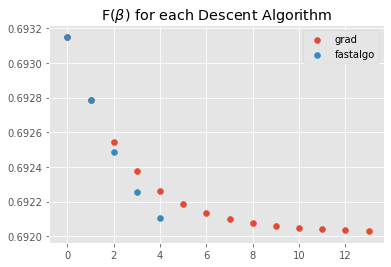

In [142]:
# Plotting of the objective function Fx_LogisticReg for each of the gradient descent algorithms
plt.scatter(x=np.array(range(len(graddesc[2]))),y=graddesc[2])
plt.scatter(x=np.array(range(len(fastAlgo[2]))),y=fastAlgo[2])
plt.ylim(min(graddesc[2])*.9999,max(graddesc[2])*1.0001)
plt.legend(["grad","fastalgo"])
plt.title(r'F($\beta$) for each Descent Algorithm')
plt.show()

From the plot we can see that both value converge to about the value 0.6919, but the $fastAlgo$ reaches this 
point at a much faster rate compared the simple $grad$ algorithm.

##### Comparing $fastAlgo$ to values from *$sklearn$*

The model from the $sklearn.linear\_model.LogisticRegression$ is provided as:
\begin{equation}
\min_{w,c} \frac{1}{2}\omega^T\omega + C\sum_{i=1}^n log(exp(-y_i(X^T_i\omega + c)) + 1)
\end{equation}

comparing this to our Logistic Regression function for $F(\beta)$, we can see that the constant $C$ from *sklearn*'s **LogisticRegression** function correlates to our $\lambda$ parameter as
\begin{equation}
C = \frac{1}{2n\lambda}
\end{equation}


In [143]:
# setting the value for "C" to pass to sklearn
c = 1/(2*lamda*(X_train.shape[0]))

# sklearn Ridge regression betas
logReg = linear_model.LogisticRegression(C=c)
model = logReg.fit(X_train,y_train)
betas_skl = model.coef_[0]

# Beta found through fastalgo model
betas = np.array(fastAlgo[0])[-1]

In [144]:
# Comparing the values for the objective function from sklearn vs fastalgo
Fx_logisticReg(betas_skl), Fx_logisticReg(betas)

(0.6920245806732075, 0.6921034629417837)

We can see that when we compare the values for $\beta^*$ vs $\beta_T$ by feeding them into the objective function **Fx_logisticReg**, the values calculated are very close between both.


If we then try to get a value for the optimal $\lambda$ by using *sklearn.linear_model.LogisticRegressionCV*. We can feed the new value of $\lambda$ to our **graddecent** and **fastdescalgo** and plot them as follows.

In [145]:
# using the 'CrossValidation' function for Logistic Regression from sklearn
logregCV = linear_model.LogisticRegressionCV()
fit = logregCV.fit(X_train,y_train)
fit.C_  # optimize value for lambda

array([0.00077426])

In [146]:
lamduh = 1/(fit.C_*(X_train.shape[0]))
lamduh 

array([0.37436222])

In [151]:
# providing the optimize value for lamda into the gradient functions
g_opt = graddescent(beta_init,eta_0,epsilon=0.005,lamda=lamduh)
f_opt = fastgradalgo(eta_0,epsilon=0.005,lamda=lamduh)

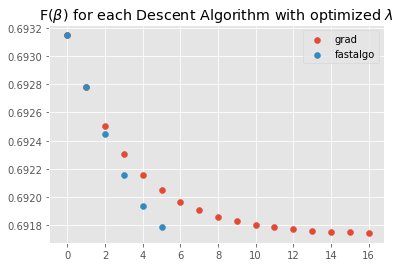

In [152]:
# Plotting of the objective function Fx_LogisticReg for each of the gradient descent algorithms
plt.scatter(x=np.array(range(len(g_opt[2]))),y=g_opt[2])
plt.scatter(x=np.array(range(len(f_opt[2]))),y=f_opt[2])
plt.ylim(min(g_opt[2])*.9999,max(g_opt[2])*1.0001)
plt.legend(["grad","fastalgo"])
plt.title(r'F($\beta$) for each Descent Algorithm with optimized $\lambda$')
plt.show()

When we compare the plots for the $\lambda_{optimized}$ vs $\lambda = 0.5$, we can see that the optimized plot has a steeper deccent.

In [153]:
def logit_model(b,X=X_train):
    fx = np.exp(X @ b)
    return fx/(1 + fx)

In [154]:
# Beta found through fastalgo model
beta_f = np.array(f_opt[0])
beta_g = np.array(g_opt[0])
p_valF = []
p_valG = []
for b in beta_f:
    y_calTrain = logit_model(b) > .5
    y_calTest = logit_model(b, X= X_test) > .5
    p_valF.append([np.average(y_calTrain != y_train),np.average(y_calTest != y_test)])
for b in beta_g:
    y_calTrain = logit_model(b) > .5
    y_calTest = logit_model(b, X= X_test) > .5
    p_valG.append([np.average(y_calTrain != y_train),np.average(y_calTest != y_test)])
p_valF = np.array(p_valF)
p_valG = np.array(p_valG)

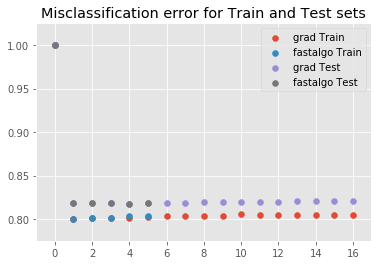

In [155]:
plt.scatter(x=np.array(range(len(p_valG))),y=p_valG[:,0])
plt.scatter(x=np.array(range(len(p_valF))),y=p_valF[:,0])
plt.scatter(x=np.array(range(len(p_valG))),y=p_valG[:,1])
plt.scatter(x=np.array(range(len(p_valF))),y=p_valF[:,1])
plt.legend(["grad Train","fastalgo Train","grad Test","fastalgo Test"])
plt.title(r'Misclassification error for Train and Test sets')
plt.show()
plt.show()

In [156]:
predictions = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

          -1       0.66      1.00      0.80       761
           1       0.00      0.00      0.00       390

    accuracy                           0.66      1151
   macro avg       0.33      0.50      0.40      1151
weighted avg       0.44      0.66      0.53      1151



/home/juansolo/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


What we can see from the plot for the misclassification error is that the test set is lower than the training set as well as the **graddescent** having a better value.

/home/juansolo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/juansolo/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in matmul
  


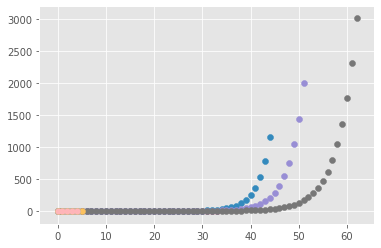

In [162]:
for i in range(0,7,1):
    f_opt = fastgradalgo(eta_0,epsilon=0.005,lamda=i/10)
    plt.scatter(x=np.array(range(len(f_opt[2]))),y=f_opt[2])
    
plt.show()

### Question 2
#### Effect of $\lambda$ on misclassification error

- a) For $\lambda$ changing in a training set, the misclassification error will follow option (ii) Decreasing initially to then increase in a U shape. This is due to the model reaching a minimum level for the misclassification as the model is optimized to no over or underfit.
- b) For $\lambda$ changing in a test set, the misclassification error will follow option (vi), as we are following the assumption the test data follows the same distribution as the train set but this might not be the case.